### Libraries

In [1]:
import os
import numpy as np
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import datetime
import pandas as pd
import re
import collections
import string
import math
%matplotlib inline

### Read data

In [2]:
filename = './data/train.csv'
train_data_ = pd.read_csv(filename)
print ('Data size:', len(train_data_))
train_data_.head()

Data size: 3947


,Insult,Date,Comment
0,1,20120618192155Z,"""You fuck your dad."""
1,0,20120528192215Z,"""i really don't understand your point.\xa0 It ..."
2,0,NaN,"""A\\xc2\\xa0majority of Canadians can and has ..."
3,0,NaN,"""listen if you dont wanna get married to a man..."
4,0,20120619094753Z,"""C\xe1c b\u1ea1n xu\u1ed1ng \u0111\u01b0\u1edd..."


In [3]:
filename = './data/test_with_solutions.csv'
valid_data_ = pd.read_csv(filename)
print ('Data size:', len(valid_data_))
valid_data_.head()

Data size: 2647


,Insult,Date,Comment,Usage
0,0,NaN,"""THE DRUDGE REPORT\\n\\n\\n\\nYou won't see th...",PublicTest
1,0,20120618222256Z,"""@ian21\xa0""Roger Clemens is the fucking man, ...",PublicTest
2,1,20120618213617Z,"""Agree with Alan you are an extremest idiot. ...",PublicTest
3,0,NaN,"""Really?\\n\\nI see Marc Lamont Hill on variou...",PrivateTest
4,0,20120620003825Z,"""Really suck isn't the word, when many of our ...",PrivateTest


In [4]:
filename = './data/test.csv'
test_data_ = pd.read_csv(filename)
print ('Data size:', len(test_data_))
test_data_.head()

Data size: 2235


,id,Date,Comment
0,1,20120603163526Z,"""like this if you are a tribe fan"""
1,2,20120531215447Z,"""you're idiot......................."""
2,3,20120823164228Z,"""I am a woman Babs, and the only ""war on women..."
3,4,20120826010752Z,"""WOW & YOU BENEFITTED SO MANY WINS THIS YEAR F..."
4,5,20120602223825Z,"""haha green me red you now loser whos winning ..."


### Data preprocessing

In [5]:
def data_preprocessing(data):
    max_sym_len = 0
    max_word_len = 0
    lens_in_words = []
    lens_in_symbs = []
    
    for i, comment in enumerate(data['Comment']):
        data.iloc[i,2] = data.iloc[i,2].lower()
        data.iloc[i,2] = re.sub('n\'t', ' not', data.iloc[i,2])
        data.iloc[i,2] = re.sub('\'m', ' ', data.iloc[i,2])
        data.iloc[i,2] = re.sub('\'s', ' ', data.iloc[i,2])
        data.iloc[i,2] = re.sub('\'re', ' ', data.iloc[i,2])
        data.iloc[i,2] = re.sub('\'ve', ' ', data.iloc[i,2])
        data.iloc[i,2] = re.sub('\'d', ' ', data.iloc[i,2])
        data.iloc[i,2] = re.sub(' im ', ' i', data.iloc[i,2])
        data.iloc[i,2] = re.sub(' ur ', ' you ', data.iloc[i,2])
        #data.iloc[i,2] = re.sub('\? ', ' ', data.iloc[i,2])
        #data.iloc[i,2] = re.sub('[!?]+', ' mysignssymbol ', data.iloc[i,2])
        data.iloc[i,2] = re.sub(r'href=[\'"]?([^\'" >]+)', ' ', data.iloc[i,2])
        data.iloc[i,2] = re.sub('[^a-z]+', ' ', data.iloc[i,2]) # replace everything not lowercase literals with space
        data.iloc[i,2] = re.sub('\s+', ' ',  data.iloc[i,2] ).strip() #replace multiple spaces
        for letter in string.ascii_lowercase: #replace multiple letters (3 and more) 
            data.iloc[i,2] = re.sub(letter * 3 + '+', letter,  data.iloc[i,2] ).strip() 
        #data.iloc[i,2] = re.sub('mysignssymbol', '<SIGNS>', data.iloc[i,2])
        data.iloc[i,2] = re.sub('\s+', ' ',  data.iloc[i,2] ).strip() #replace multiple spaces
        if max_sym_len < len(comment):
            max_sym_len = len(comment)
        if max_word_len < len(comment.split(' ')):
            max_word_len = len(comment.split(' '))
        lens_in_words.append(len(comment.split(' ')))
        lens_in_symbs.append(len(comment))
    print ('Max comment length in symbols:', max_sym_len)
    print ('Max comment length in words:  ', max_word_len)
    plt.plot(np.arange(len(lens_in_symbs)), np.asarray(lens_in_symbs))
    plt.xlabel('Comment')
    plt.ylabel('Length in symbols')
    return data

Max comment length in symbols: 17805
Max comment length in words:   2407
Max comment length in symbols: 20030
Max comment length in words:   1419
Max comment length in symbols: 1437
Max comment length in words:   224


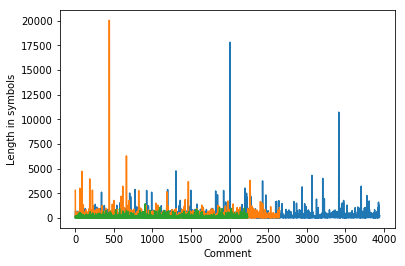

In [6]:
train_data = data_preprocessing(train_data_)
valid_data = data_preprocessing(valid_data_)
test_data = data_preprocessing(test_data_)

valid_size = len(valid_data)
train_size = len(train_data)
test_size = len(test_data)

X_train = train_data['Comment']
y_train = train_data['Insult']
X_valid = valid_data['Comment']
y_valid = valid_data['Insult']
X_test = test_data['Comment']
y_test = test_data['id']

test_data_ = test_data_.drop('id', axis=1)

### Character indexing

In [7]:
vocabulary_size = len(string.ascii_lowercase) + 1 + 1 + 1  # [a-z] + ' ' + END + PAD
first_letter = ord(string.ascii_lowercase[0])

def char2id(char):
    if char in string.ascii_lowercase:
        return ord(char) - first_letter + 1
    elif char == ' ':
        return 0
    elif char == 'E':
        return 27
    elif char == 'P':
        return 28
    else:
        print('Unexpected character: %s' % char)
        return 0
    
def id2char(dictid):
    if dictid > 0 and dictid < 27: # id(z) = 26
        return chr(dictid + first_letter - 1)
    elif dictid == 27:
        return 'E'
    elif dictid == 28:
        return 'P'
    else:
        return ' '

def comment2vec(comment_, comment_size):
    N = len(comment_)
    if N > comment_size - 2:
        comment = comment_[:comment_size - 1] + 'E'
    else:
        comment = comment_ + 'E' + 'P' * (comment_size - N - 1)
    res = np.array([char2id(char) for char in comment], dtype='int')
    return res
    
print(char2id('a'), char2id('z'), char2id(' '), char2id('ï'))
print(id2char(1), id2char(26), id2char(0))

Unexpected character: ï
1 26 0 0
a z  


### Generation of batches

In [8]:
class LabeledBatchGenerator(object):
    def __init__(self, comments, batch_size, comment_size, labels):
        self._comments = comments
        self._num_comments = len(comments)
        self._batch_size = batch_size
        self._comment_size = comment_size
        self._labels = labels
        segment = self._num_comments // batch_size
        self._cursor = [offset * segment for offset in range(batch_size)]
        
    def _next_batch(self, step):
        batch = np.zeros(shape=(self._batch_size,1), dtype=np.int)
        for b in range(self._batch_size):
            comment = comment2vec(self._comments[self._cursor[b]], self._comment_size)
            batch[b,0] = comment[step]
            if step == self._comment_size - 1:
                self._cursor[b] = (self._cursor[b] + 1) % self._num_comments
        return batch
    
    def next(self):
        batches = []
        batches_labels = [self._labels[self._cursor[b]] for b in range(self._batch_size)]
        for step in range(0, self._comment_size):
            batches.append(self._next_batch(step))
        return batches, batches_labels

In [114]:
comment_size = 100
batch_size = 128
valid_batch_size = valid_size
test_batch_size = test_size

train_batch_generator = LabeledBatchGenerator(X_train.as_matrix(), batch_size, comment_size, y_train.as_matrix())
valid_batch_generator = LabeledBatchGenerator(X_valid.as_matrix(), valid_batch_size, comment_size, y_valid.as_matrix())
test_batch_generator = LabeledBatchGenerator(X_test.as_matrix(), test_batch_size, comment_size, y_test.as_matrix())

In [115]:
def plot_results(losses_, mean_losses_, train_aucs_, valid_aucs_, frequency):
    plt.plot(losses_)
    plt.title('Losses')
    plt.xlabel('Step')
    plt.show()

    plt.plot(frequency * np.arange(1,len(mean_losses_)+1), mean_losses_)
    plt.title('MeanLosses')
    plt.xlabel('Step')
    plt.show()

    plt.plot(train_aucs_, label='Train AUC-ROC')
    plt.plot(frequency * np.arange(1,len(valid_aucs_)+1), valid_aucs_, label='Valid AUC-ROC')
    plt.xlabel('Step')
    plt.title('AUC-ROC')
    plt.legend()
    plt.show()

### Tensorflow graph

In [116]:
embedding_size = 128
patch_size = [3,3,3]
num_filters = 128
pool_size = 2

graph = tf.Graph()
with graph.as_default():
    tf_embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    tf_keep_prob = tf.placeholder(tf.float32)
    tf_data = list()
    tf_labels = tf.placeholder(tf.float32, shape=[None,1])
    for _ in range(comment_size):
        tf_data.append(tf.placeholder(tf.int32, shape=[None, 1]))  
    tf_inputs = tf.concat(tf_data[:comment_size], axis=1)    
    tf_embedded_inputs = tf.nn.embedding_lookup(tf_embeddings, tf_inputs) # batch_size, comment_size, embed_size

    tf_w0 = tf.Variable(tf.truncated_normal(
            [patch_size[0], embedding_size, num_filters], stddev=0.1))
    tf_w1 = tf.Variable(tf.truncated_normal(
            [patch_size[1], embedding_size, num_filters], stddev=0.1))
    tf_w2 = tf.Variable(tf.truncated_normal(
            [patch_size[2], embedding_size, num_filters], stddev=0.1))
    
    def multi_layer_cnn(data):
        output = []
        conv = tf.nn.conv1d(data, tf_w0, 1, padding='SAME')
        conv = tf.nn.relu(conv)
        pool = tf.nn.max_pool(tf.expand_dims(conv,-1), [1, pool_size, pool_size, 1], [1, 1, 1, 1], 'VALID')
        pool = tf.nn.relu(pool)
        pool = tf.squeeze(pool, axis=3)
        output.append(pool)
        
        conv = tf.nn.conv1d(data, tf_w1, 1, padding='SAME')
        conv = tf.nn.relu(conv)
        pool = tf.nn.max_pool(tf.expand_dims(conv,-1), [1, pool_size, pool_size, 1], [1, 1, 1, 1], 'VALID')
        pool = tf.nn.relu(pool)
        pool = tf.squeeze(pool, axis=3)
        output.append(pool)
        
        conv = tf.nn.conv1d(data, tf_w2, 1, padding='SAME')
        conv = tf.nn.relu(conv)
        pool = tf.nn.max_pool(tf.expand_dims(conv,-1), [1, pool_size, pool_size, 1], [1, 1, 1, 1], 'VALID')
        pool = tf.nn.relu(pool)
        pool = tf.squeeze(pool, axis=3)
        output.append(pool)
        
        output = tf.concat(output, axis=2)
        print (output.shape)
        
        shape = output.get_shape().as_list()
        reshape = tf.reshape(output, [-1, shape[1] * shape[2]])
        return tf.layers.dense(inputs=reshape, units=1, activation=None, kernel_regularizer=tf.nn.l2_loss)

    tf_logits = tf.nn.dropout(multi_layer_cnn(tf_embedded_inputs), tf_keep_prob)
    #tf_logits = multi_layer_cnn(tf_embedded_inputs)
    tf_loss = (tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=tf_logits, labels=tf_labels)) )
    tf_global_step = tf.Variable(0, trainable=False)
    tf_learning_rate = tf.train.exponential_decay(0.001, tf_global_step,
                                               1000, 0.9, staircase=True)
    #optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    #train_op = optimizer.minimize(loss, global_step=global_step)
    tf_optimizer = tf.train.AdamOptimizer(tf_learning_rate)
    tf_grads = tf_optimizer.compute_gradients(tf_loss)
    tf_op = tf_optimizer.apply_gradients(tf_grads, global_step=tf_global_step)

    tf_prediction = tf.round(tf.sigmoid(tf_logits))
    tf_auc_roc, tf_update_oper = tf.metrics.auc(tf_labels, tf_prediction)
    
    print('Graph is ready!')

(?, 99, 381)
Graph is ready!


In [117]:
t0 = datetime.datetime.now()
losses = []
train_aucs = []
valid_aucs = []
num_steps = 1001
frequency = 100
mean_losses = []

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    tf.local_variables_initializer().run()
    print('Initialized')
    mean_loss = 0.
    
    for step in range(num_steps):
        batches, labels = train_batch_generator.next()
        feed_dict = dict()
        for i in range(comment_size):
            feed_dict[tf_data[i]] = batches[i]
        train_labels_ = np.asarray(labels).astype('float').reshape(-1,1)
        feed_dict[tf_labels] = train_labels_
        feed_dict[tf_keep_prob] = 0.9
        l, update, auc, predictions, _ = session.run([tf_loss, tf_update_oper, tf_auc_roc,
                                                   tf_prediction, tf_op],
                                                  feed_dict=feed_dict)
        mean_loss += l
        losses.append(l)
        train_aucs.append(auc)
        if step % frequency == 0 and step > 0:
            mean_loss /= frequency
            print ('\nStep %d' % step)
            print ('True:',np.asarray(labels).astype('int'))
            print ('Pred:',predictions.astype('int').reshape(-1))
            print ('Train loss: %.5f' % mean_loss)
            print ('Train batch AUC-ROC: %.5f ' % auc)
            mean_losses.append(mean_loss)
            mean_loss = 0.
            valid_predictions = []
            valid_true = []
            for _ in range(1):
                valid_b, valid_lab = valid_batch_generator.next()
                feed_dict = dict()
                for i in range(comment_size):
                    feed_dict[tf_data[i]] = valid_b[i]
                feed_dict[tf_labels] = np.asarray(valid_lab).astype('float').reshape(-1,1)
                feed_dict[tf_keep_prob] = 1.
                valid_pred, valid_auc, valid_update = session.run([tf_prediction, tf_auc_roc, tf_update_oper], 
                                                                  feed_dict=feed_dict)
                valid_true.append(valid_lab)
                valid_predictions.append(valid_pred)
            print('Valid true:     ', np.asarray(valid_true).astype('int').reshape(-1)[:100])
            print('Valid predicted:', np.asarray(valid_predictions).astype('int').reshape(-1)[:100])
            print('Validation AUC-ROC:  %.5f\n' % valid_auc)
            valid_aucs.append(valid_auc)
    
    test_predictions = []
    for _ in range(1):
        test_b, __ = test_batch_generator.next()
        feed_dict = dict()
        for i in range(comment_size):
            feed_dict[tf_data[i]] = test_b[i]
        feed_dict[tf_keep_prob] = 1.
        test_pred = session.run([tf_prediction], feed_dict=feed_dict)
        test_predictions.append(test_pred)
    print('Test predicted:', np.asarray(test_predictions).astype('int').reshape(-1)[:100])
    test_data_.insert(loc=0, column='Insult', value=np.asarray(test_predictions).astype('int').reshape(-1))
    test_data_.to_csv('./data/insult_subm_v9_characterCNN.csv', index=False)
    test_data_ = test_data_.drop('Insult', axis=1)
t1 = datetime.datetime.now()
print ('TIME:', t1 - t0)

Initialized

Step 100
True: [1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 1 0 0 1 0 0 0 1
 1 1 1 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 1 0 1 0 0 0 0 0 1 0 1 1 0
 0 1 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 1 0 1 0 0 0 1 0 0 1 1 1 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
Pred: [1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0
 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 0 1 0 0 0 0 0 1 0 1 1 0
 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
Train loss: 1.43196
Train batch AUC-ROC: 0.60028 
Valid true:      [0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 1 0 0 0 0 1 1
 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 0 0]
Valid predicted: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1
 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0

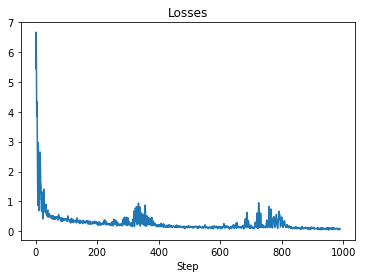

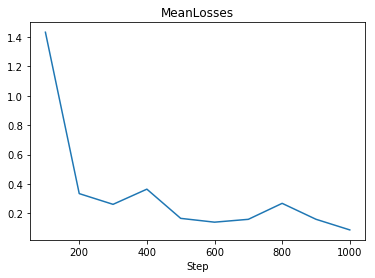

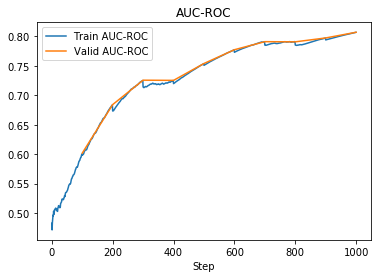

In [118]:
plot_results(losses[10:], mean_losses, train_aucs[1:], valid_aucs, frequency)